## 1. Credit card applications
<p>Commercial banks receive <em>a lot</em> of applications for credit cards. Many of them get rejected for many reasons, like high loan balances, low income levels, or too many inquiries on an individual's credit report, for example. Manually analyzing these applications is mundane, error-prone, and time-consuming (and time is money!). Luckily, this task can be automated with the power of machine learning and pretty much every commercial bank does so nowadays. In this notebook, we will build an automatic credit card approval predictor using machine learning techniques, just like the real banks do!</p>

<p>We'll use the <a href="http://archive.ics.uci.edu/ml/datasets/credit+approval">Credit Card Approval dataset</a> from the UCI Machine Learning Repository. The structure of this notebook is as follows:</p>

# Import libraries

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_val_predict
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder, LabelEncoder
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [64]:
# Surpress warnings:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

# Get data

## Load dataset

In [2]:
# Load dataset
df = pd.read_csv("datasets/cc_approvals.data", header=None)

In [3]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,+


# Data cleanup

In [4]:
# Transform columns to correct names
cc_approvals = df.rename(
    columns = {0 :'Gender', 
               1 :'Age', 
               2 : 'Debt',
               3 : 'Married',
               4 : 'Bank_Customer', 
               5 : 'Education_Level', 
               6 : 'Ethnicity',
               7 : 'Years_Employed', 
               8 : 'Prior_Default', 
               9 :'Employed', 
               10 : 'Credit_Score',
               11 : 'Drivers_License',
               12 : 'Citizen',
               13 : 'ZipCode',
               14 : 'Income',
               15 : 'Approval_Status'},
    errors="raise")

In [5]:
cc_approvals['Approval_Status'].value_counts()

Approval_Status
-    383
+    307
Name: count, dtype: int64

In [6]:
# Turning the '+' to a '1' and the '-' to a '0'
cc_approvals.replace({
    'Approval_Status': {'+': 1, '-': 0},
}, inplace=True)

In [10]:
# Replace the '?'s with NaN
cc_approvals = cc_approvals.replace("?",np.NaN)

In [11]:
cc_approvals['Age'] = pd.to_numeric(cc_approvals['Age'])

# Quick glance at the data

In [12]:
cc_approvals.head()

,Gender,Age,Debt,Married,Bank_Customer,Education_Level,Ethnicity,Years_Employed,Prior_Default,Employed,Credit_Score,Drivers_License,Citizen,ZipCode,Income,Approval_Status
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,0,1
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,1
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,1
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,1
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,1


In [17]:
# DataFrame information
cc_approvals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Gender           678 non-null    object 
 1   Age              678 non-null    float64
 2   Debt             690 non-null    float64
 3   Married          684 non-null    object 
 4   Bank_Customer    684 non-null    object 
 5   Education_Level  681 non-null    object 
 6   Ethnicity        681 non-null    object 
 7   Years_Employed   690 non-null    float64
 8   Prior_Default    690 non-null    object 
 9   Employed         690 non-null    object 
 10  Credit_Score     690 non-null    int64  
 11  Drivers_License  690 non-null    object 
 12  Citizen          690 non-null    object 
 13  ZipCode          677 non-null    object 
 14  Income           690 non-null    int64  
 15  Approval_Status  690 non-null    int64  
dtypes: float64(3), int64(3), object(10)
memory usage: 86.4+ KB


In [16]:
# Descriptive Statistics
cc_approvals.describe()

,Age,Debt,Years_Employed,Credit_Score,Income,Approval_Status
count,678.000000,690.000000,690.000000,690.00000,690.000000,690.000000
mean,31.568171,4.758725,2.223406,2.40000,1017.385507,0.444928
std,11.957862,4.978163,3.346513,4.86294,5210.102598,0.497318
min,13.750000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,22.602500,1.000000,0.165000,0.00000,0.000000,0.000000
50%,28.460000,2.750000,1.000000,0.00000,5.000000,0.000000
75%,38.230000,7.207500,2.625000,3.00000,395.500000,1.000000
max,80.250000,28.000000,28.500000,67.00000,100000.000000,1.000000


## Univariate analysis

In [18]:
#Function that will return the value count and frequency of each observation within a column
def value_cnt_norm_cal(df,feature):
    ftr_value_cnt = df[feature].value_counts()
    ftr_value_cnt_norm = df[feature].value_counts(normalize=True) * 100
    ftr_value_cnt_concat = pd.concat([ftr_value_cnt, ftr_value_cnt_norm], axis=1)
    ftr_value_cnt_concat.columns = ['Count', 'Frequency (%)']
    return ftr_value_cnt_concat

### Gender

In [19]:
value_cnt_norm_cal(cc_approvals, 'Gender')

,Count,Frequency (%)
Gender,,
b,468,69.026549
a,210,30.973451


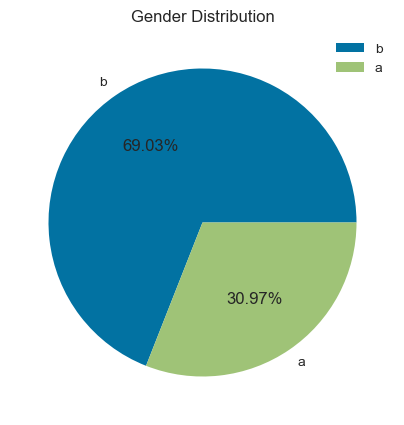

In [20]:
fig, ax = plt.subplots(figsize=(5,5))
plt.pie(cc_approvals['Gender'].value_counts(), labels=cc_approvals['Gender'].value_counts().index, autopct='%1.2f%%')
plt.title('Gender Distribution')
plt.legend(loc='upper right')
plt.show()

### Gender distribution approval status

In [21]:
cc_approvals.groupby('Gender')['Approval_Status'].value_counts(normalize=True)

Gender  Approval_Status
a       0                  0.533333
        1                  0.466667
b       0                  0.559829
        1                  0.440171
Name: proportion, dtype: float64

## Age

In [23]:
cc_approvals['Age'].describe()

count    678.000000
mean      31.568171
std       11.957862
min       13.750000
25%       22.602500
50%       28.460000
75%       38.230000
max       80.250000
Name: Age, dtype: float64

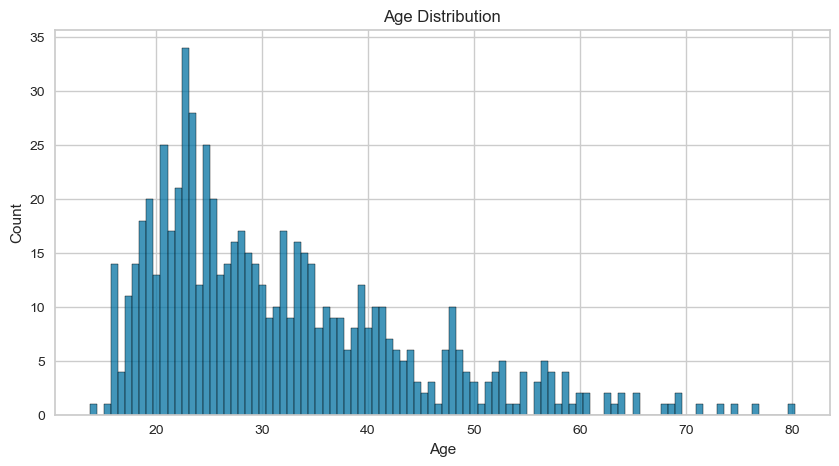

In [24]:
fig, ax = plt.subplots(figsize=(10,5))
ax.ticklabel_format(style='plain')
sns.histplot(cc_approvals['Age'],bins=100)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.show()

## Debt

In [25]:
cc_approvals['Debt'].describe()

count    690.000000
mean       4.758725
std        4.978163
min        0.000000
25%        1.000000
50%        2.750000
75%        7.207500
max       28.000000
Name: Debt, dtype: float64

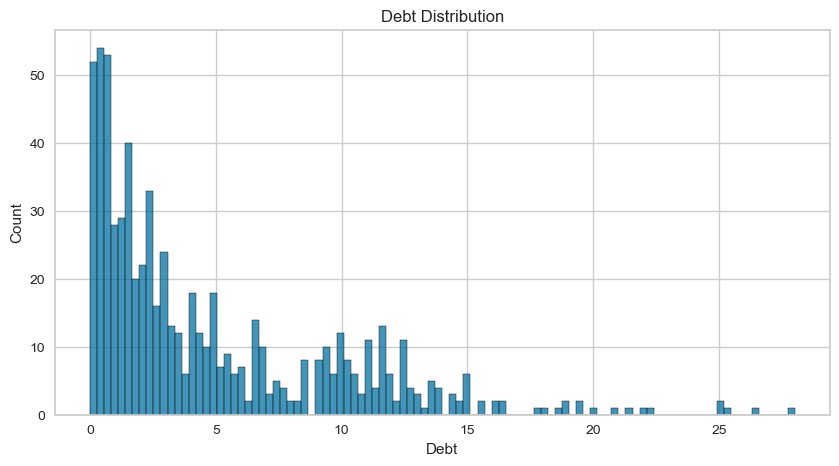

In [26]:
fig, ax = plt.subplots(figsize=(10,5))
ax.ticklabel_format(style='plain')
sns.histplot(cc_approvals['Debt'],bins=100)
plt.title('Debt Distribution')
plt.xlabel('Debt')
plt.show()

## Married Status

In [27]:
value_cnt_norm_cal(cc_approvals, 'Married')

,Count,Frequency (%)
Married,,
u,519,75.877193
y,163,23.830409
l,2,0.292398


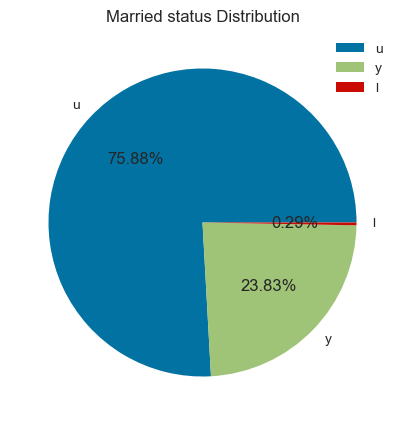

In [28]:
fig, ax = plt.subplots(figsize=(5,5))
plt.pie(cc_approvals['Married'].value_counts(), labels=cc_approvals['Married'].value_counts().index, autopct='%1.2f%%')
plt.title('Married status Distribution')
plt.legend(loc='upper right')
plt.show()

### Married applicants approval status

In [30]:
cc_approvals.groupby('Married')['Approval_Status'].value_counts(normalize=True)

Married  Approval_Status
l        1                  1.000000
u        0                  0.506744
         1                  0.493256
y        0                  0.723926
         1                  0.276074
Name: proportion, dtype: float64

## Bank Customer

In [31]:
value_cnt_norm_cal(cc_approvals, 'Bank_Customer')

,Count,Frequency (%)
Bank_Customer,,
g,519,75.877193
p,163,23.830409
gg,2,0.292398


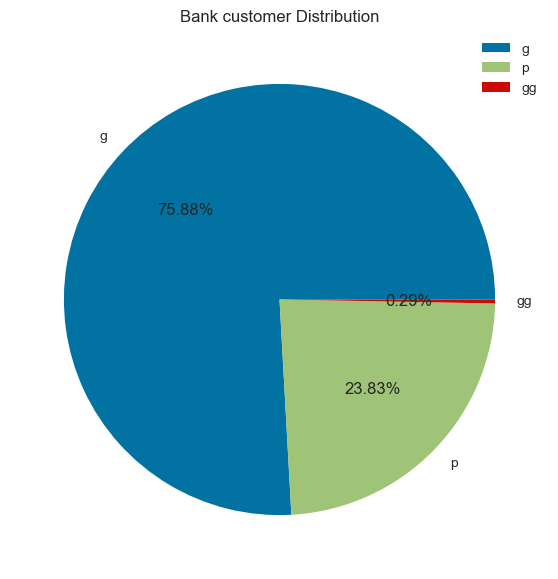

In [33]:
fig, ax = plt.subplots(figsize=(7,7))
plt.pie(cc_approvals['Bank_Customer'].value_counts(), labels=cc_approvals['Bank_Customer'].value_counts().index, autopct='%1.2f%%')
plt.title('Bank customer Distribution')
plt.legend(loc='upper right')
plt.show()

## Education Level

In [34]:
value_cnt_norm_cal(cc_approvals, 'Education_Level')

,Count,Frequency (%)
Education_Level,,
c,137,20.117474
q,78,11.453744
w,64,9.397944
i,59,8.663730
aa,54,7.929515
ff,53,7.782673
k,51,7.488987
cc,41,6.020558
m,38,5.580029


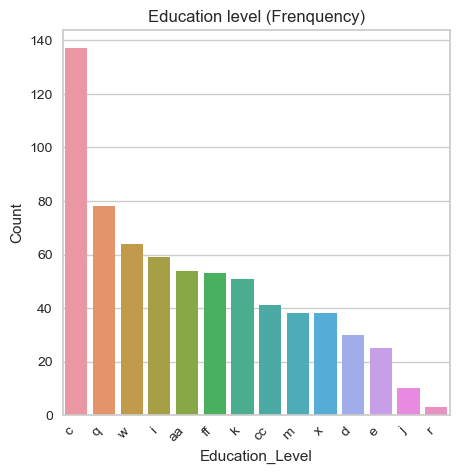

In [37]:
fig, ax = plt.subplots(figsize=(5,5))
sns.barplot(x=value_cnt_norm_cal(cc_approvals,'Education_Level').index, y=value_cnt_norm_cal(cc_approvals,'Education_Level')['Count'])
plt.title('Education level (Frenquency)')
plt.grid(True,axis='y')
plt.xticks(rotation=45,ha='right')
plt.show()

## Ethnicity

In [38]:
value_cnt_norm_cal(cc_approvals, 'Ethnicity')

,Count,Frequency (%)
Ethnicity,,
v,399,58.590308
h,138,20.264317
bb,59,8.663730
ff,57,8.370044
j,8,1.174743
z,8,1.174743
dd,6,0.881057
n,4,0.587372
o,2,0.293686


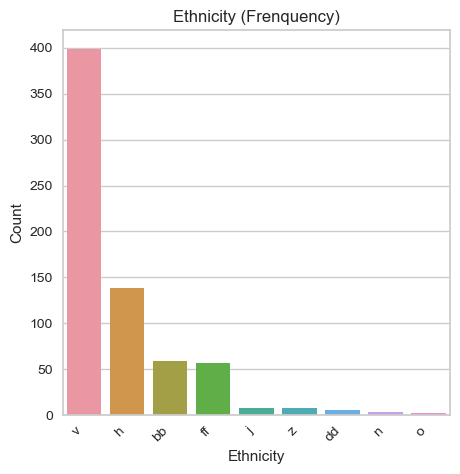

In [43]:
fig, ax = plt.subplots(figsize=(5,5))
sns.barplot(x=value_cnt_norm_cal(cc_approvals,'Ethnicity').index, y=value_cnt_norm_cal(cc_approvals,'Ethnicity')['Count'])
plt.title('Ethnicity (Frenquency)')
plt.grid(True,axis='y')
plt.xticks(rotation=45,ha='right')
plt.show()

In [44]:
cc_approvals.groupby('Ethnicity')['Approval_Status'].value_counts(normalize=True)

Ethnicity  Approval_Status
bb         0                  0.576271
           1                  0.423729
dd         0                  0.666667
           1                  0.333333
ff         0                  0.859649
           1                  0.140351
h          1                  0.630435
           0                  0.369565
j          0                  0.625000
           1                  0.375000
n          0                  0.500000
           1                  0.500000
o          0                  0.500000
           1                  0.500000
v          0                  0.576441
           1                  0.423559
z          1                  0.750000
           0                  0.250000
Name: proportion, dtype: float64

## Years Employed

In [45]:
cc_approvals['Years_Employed'].describe()

count    690.000000
mean       2.223406
std        3.346513
min        0.000000
25%        0.165000
50%        1.000000
75%        2.625000
max       28.500000
Name: Years_Employed, dtype: float64

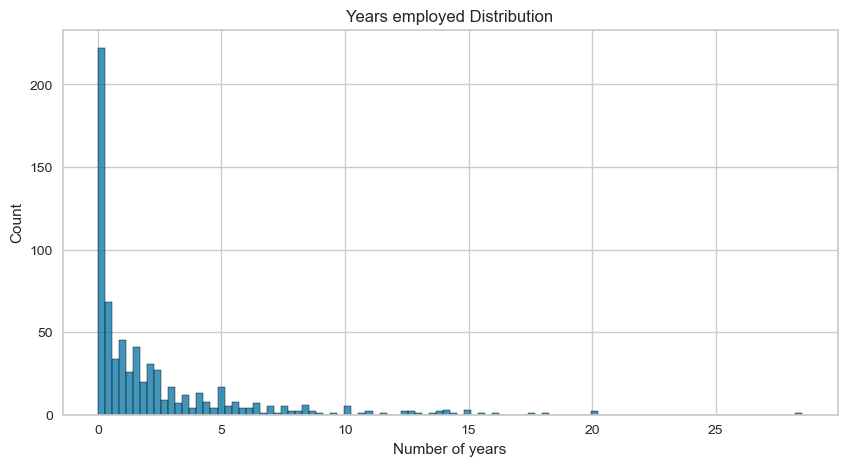

In [46]:
fig, ax = plt.subplots(figsize=(10,5))
ax.ticklabel_format(style='plain')
sns.histplot(cc_approvals['Years_Employed'],bins=100)
plt.title('Years employed Distribution')
plt.xlabel('Number of years')
plt.show()

## Prior Default

In [47]:
value_cnt_norm_cal(cc_approvals, 'Prior_Default')

,Count,Frequency (%)
Prior_Default,,
t,361,52.318841
f,329,47.681159


## Employed

In [49]:
value_cnt_norm_cal(cc_approvals, 'Employed')

,Count,Frequency (%)
Employed,,
f,395,57.246377
t,295,42.753623


### Question: How do the incomes of those who are employed compare to those who are not employed?

In [50]:
cc_approvals.groupby('Employed')['Income'].describe()

,count,mean,std,min,25%,50%,75%,max
Employed,,,,,,,,
f,395.0,668.007595,5402.444882,0.0,0.0,0.0,50.0,100000.0
t,295.0,1485.196610,4911.045479,0.0,2.5,168.0,1000.0,51100.0


## Credit Score

In [51]:
cc_approvals['Credit_Score'].describe()

count    690.00000
mean       2.40000
std        4.86294
min        0.00000
25%        0.00000
50%        0.00000
75%        3.00000
max       67.00000
Name: Credit_Score, dtype: float64

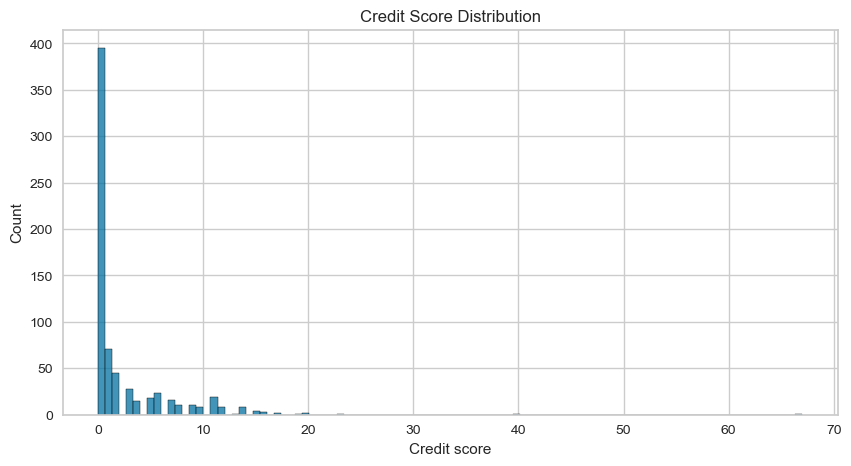

In [52]:
fig, ax = plt.subplots(figsize=(10,5))
ax.ticklabel_format(style='plain')
sns.histplot(cc_approvals['Credit_Score'],bins=100)
plt.title('Credit Score Distribution')
plt.xlabel('Credit score')
plt.show()

## Citizen

In [55]:
value_cnt_norm_cal(cc_approvals, 'Citizen')

,Count,Frequency (%)
Citizen,,
g,625,90.57971
s,57,8.26087
p,8,1.15942


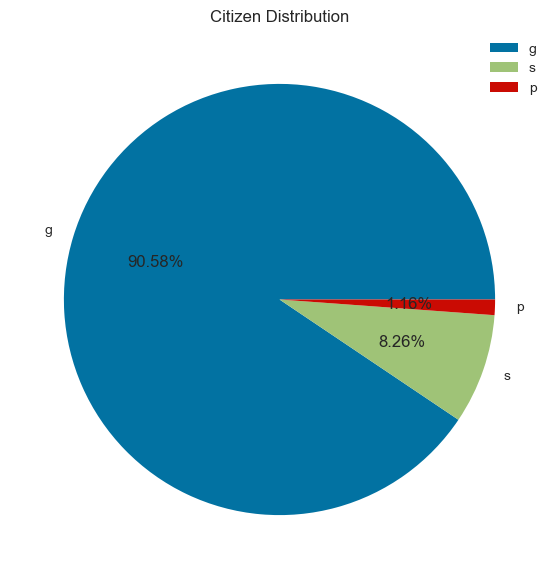

In [56]:
fig, ax = plt.subplots(figsize=(7,7))
plt.pie(cc_approvals['Citizen'].value_counts(), labels=cc_approvals['Citizen'].value_counts().index, autopct='%1.2f%%')
plt.title('Citizen Distribution')
plt.legend(loc='upper right')
plt.show()

In [57]:
cc_approvals.groupby('Citizen')['Approval_Status'].value_counts(normalize=True)

Citizen  Approval_Status
g        0                  0.540800
         1                  0.459200
p        1                  0.625000
         0                  0.375000
s        0                  0.736842
         1                  0.263158
Name: proportion, dtype: float64

## Income

In [58]:
cc_approvals['Income'].describe()

count       690.000000
mean       1017.385507
std        5210.102598
min           0.000000
25%           0.000000
50%           5.000000
75%         395.500000
max      100000.000000
Name: Income, dtype: float64

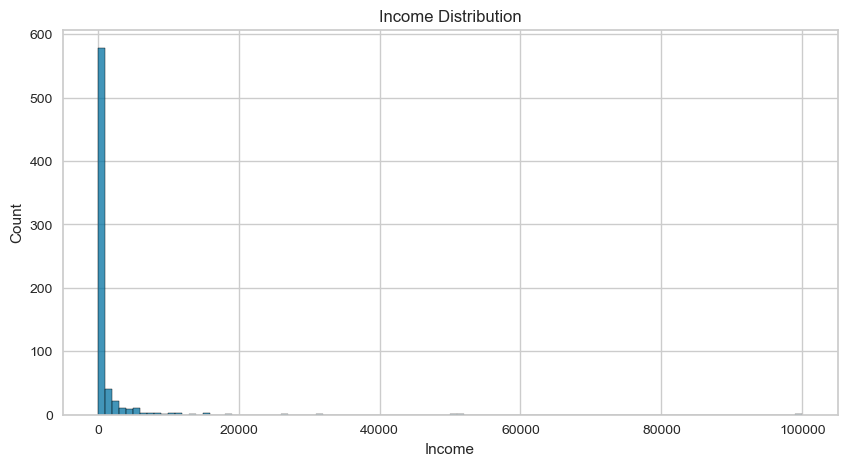

In [59]:
fig, ax = plt.subplots(figsize=(10,5))
ax.ticklabel_format(style='plain')
sns.histplot(cc_approvals['Income'],bins=100)
plt.title('Income Distribution')
plt.xlabel('Income')
plt.show()

## Approval Status (Target Variable)

In [61]:
value_cnt_norm_cal(cc_approvals, 'Approval_Status')

,Count,Frequency (%)
Approval_Status,,
0,383,55.507246
1,307,44.492754


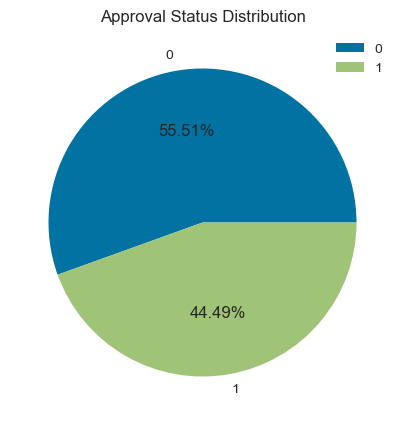

In [63]:
fig, ax = plt.subplots(figsize=(5,5))
plt.pie(cc_approvals['Approval_Status'].value_counts(), labels=cc_approvals['Approval_Status'].value_counts().index, autopct='%1.2f%%')
plt.title('Approval Status Distribution')
plt.legend(loc='upper right')
plt.show()

**Overview**: The majority of the loans in the dataset, approximately 55.1% (383 out of 690), have been rejected, while the remaining 44.49% (307 out of 690) have been accepted. 

## Bivariate analysis

### Scatter plots

Text(0.5, 0.98, 'Pairplot: Numerical Features ')

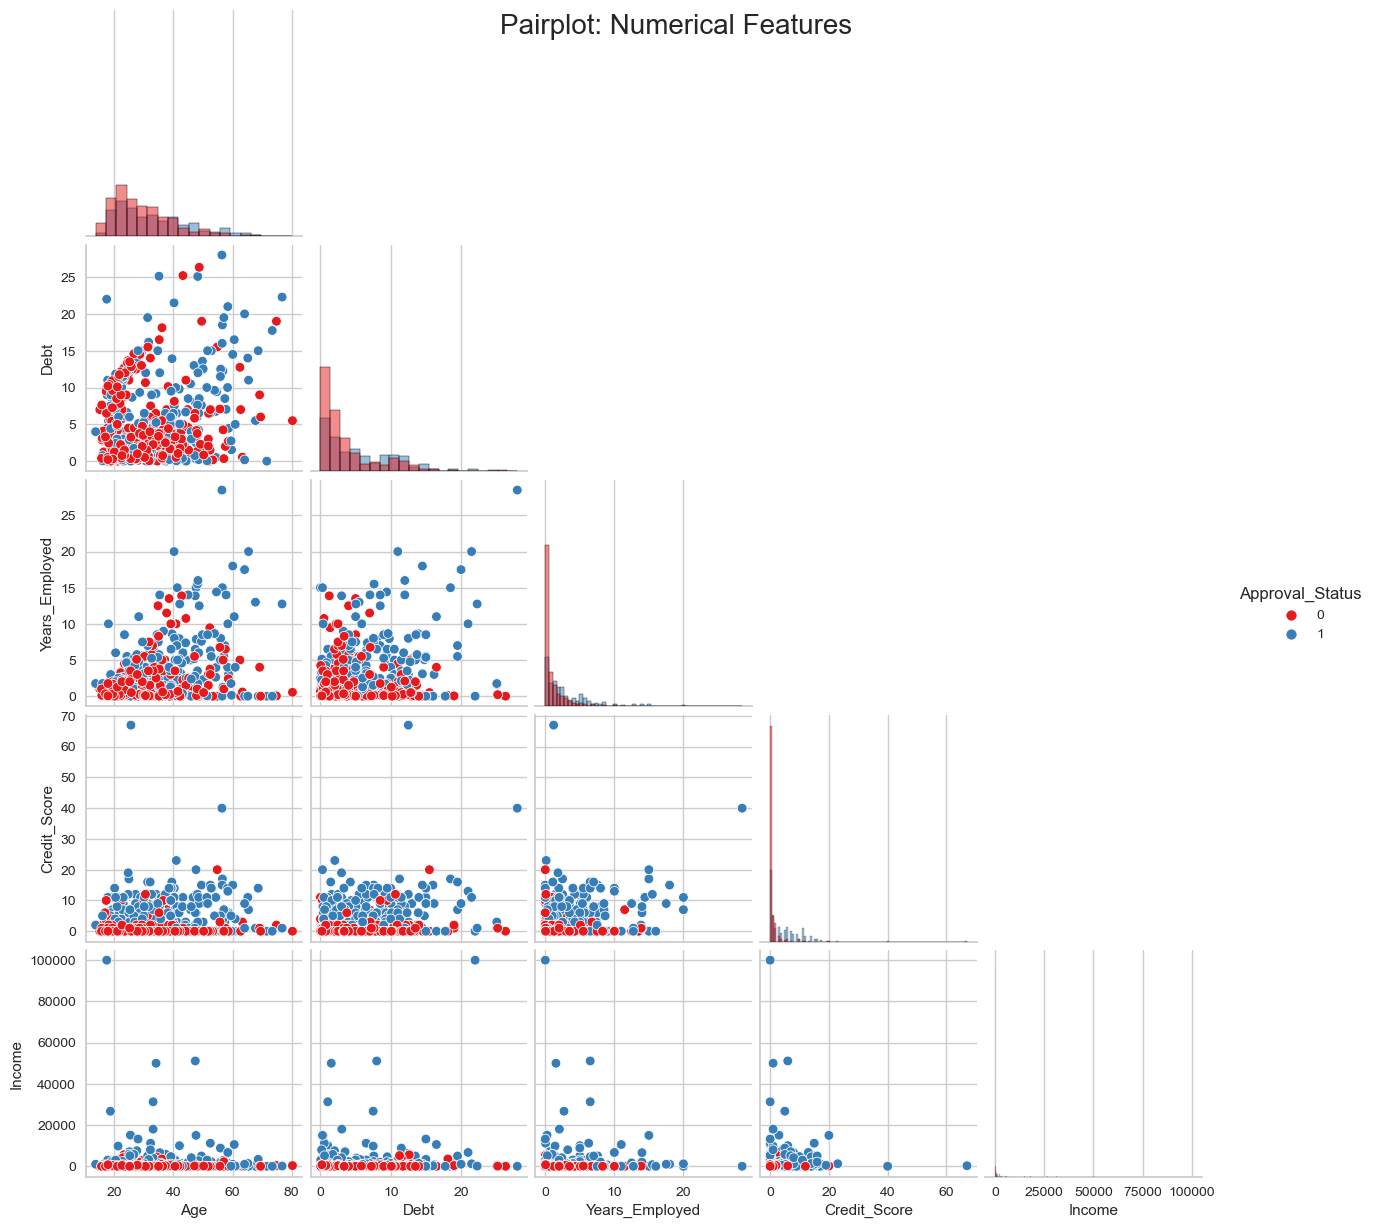

In [65]:
# Pairplots of Numerical Features
cc_numerical= ['Age', 'Debt', 'Years_Employed','Credit_Score', 'Income', 'Approval_Status']
data = cc_approvals[cc_numerical]
g = sns.pairplot(data, hue="Approval_Status", corner=True, diag_kind='hist', palette='Set1');
plt.suptitle('Pairplot: Numerical Features ' ,fontsize = 20)

## Correlation Analysis

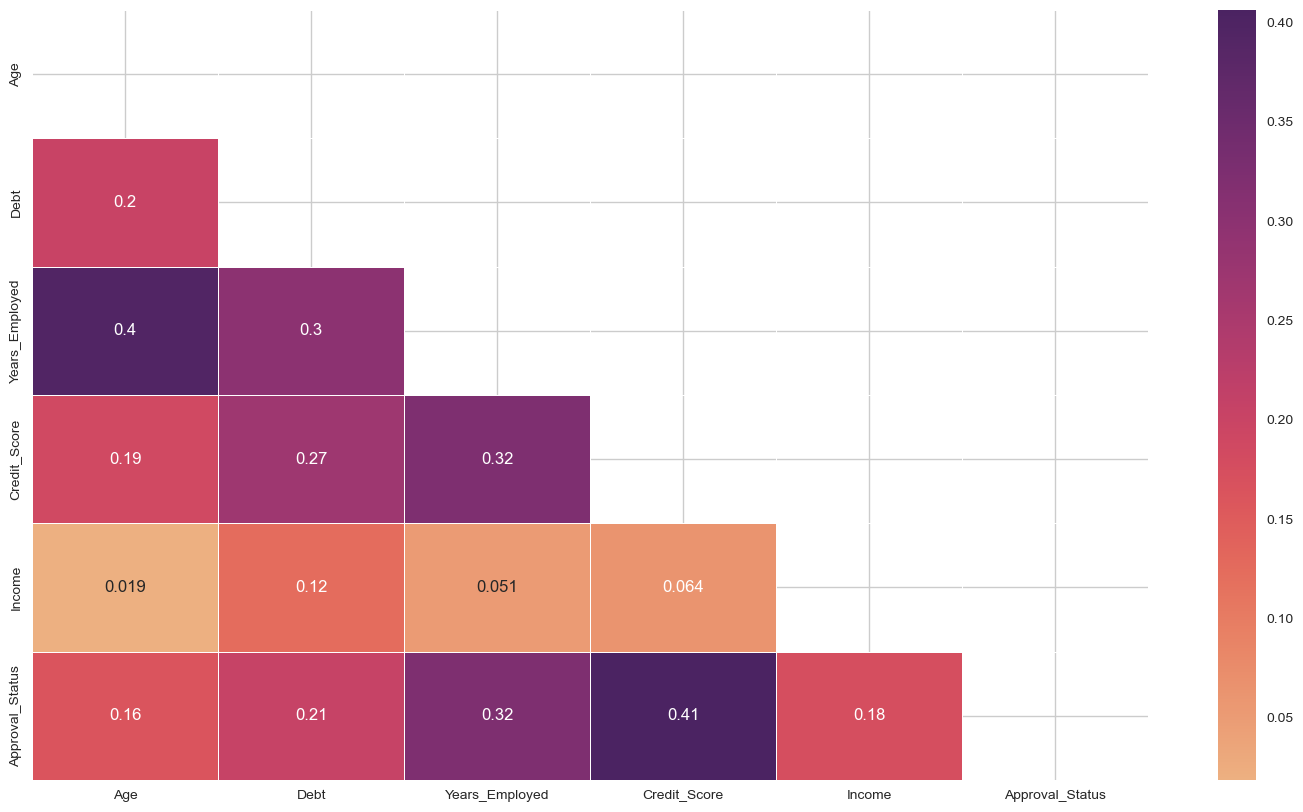

In [67]:
corr = cc_approvals.drop(['Gender', 'Married', 'Bank_Customer', 'Education_Level', 'Ethnicity', 'Prior_Default', 'Employed', 'Drivers_License', 'Citizen', 'ZipCode'],axis=1).corr()
# Get the lower triangle of the correlation matrix
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype='bool')
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(18,10))
# seaborn heatmap
sns.heatmap(corr, annot=True, cmap='flare',mask=mask, linewidths=.5)
# plot the heatmap
plt.show()

# Prepare the data

In [69]:
df = cc_approvals[['Gender',
                   'Age',
                   'Debt',
                   'Married',
                   'Bank_Customer',
                   'Education_Level',
                   'Ethnicity',
                   'Years_Employed',
                   'Prior_Default',
                   'Employed',
                   'Credit_Score',
                   'Citizen',
                   'Income'
                  ]]

## Imputing the missing values

In [71]:
# imputing the missing values:
df['Gender'].fillna(df['Gender'].mode()[0], inplace = True)
df['Married'].fillna(df['Married'].mode()[0], inplace = True)
df['Bank_Customer'].fillna(df['Bank_Customer'].mode()[0], inplace = True)
df['Education_Level'].fillna(df['Education_Level'].mode()[0], inplace = True)
df['Age'].fillna(df['Age'].mean(), inplace = True)

## Encoding categorical features

In [74]:
# Instantiate LabelEncoder
le = LabelEncoder()

# Iterate over all the values of each column and extract their dtypes
for col in df.columns:
    # Compare if the dtype is object
    if df[col].dtype=='object':
    # Use LabelEncoder to do the numeric transformation
        df[col]=le.fit_transform(df[col])

## Train-test split

In [ ]:
X = df.copy()
y = cc_approvals['Approval_Status']

In [76]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Min-Max scaler

In [77]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Making predictions and evaluating performance

In [78]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

In [80]:
model_list = [
    LogisticRegression(random_state=42),
    KNeighborsClassifier(),
    GradientBoostingClassifier(random_state=42),
    RandomForestClassifier(random_state=42),
    DecisionTreeClassifier(random_state=42)
]

In [81]:
for model in model_list:
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    
    # Check if the model has predict_proba method
    if hasattr(model, "predict_proba"):
        y_predict_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_predict_proba = model.decision_function(X_test)
    
    print(str(model))
    print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))
    
    confusion_mat = confusion_matrix(y_test, y_predict)
    pre_score = precision_score(y_test, y_predict)
    recall = recall_score(y_test, y_predict)
    f1 = f1_score(y_test, y_predict)
    
    print(confusion_mat)
    print('Precision Score is {:.5}'.format(pre_score))
    print('Recall Score is {:.5}'.format(recall))
    print('F1 Score is {:.5}'.format(f1))
    
    print('\n')

LogisticRegression(random_state=42)
Accuracy Score is 0.83333
[[53 15]
 [ 8 62]]
Precision Score is 0.80519
Recall Score is 0.88571
F1 Score is 0.84354


KNeighborsClassifier()
Accuracy Score is 0.84783
[[61  7]
 [14 56]]
Precision Score is 0.88889
Recall Score is 0.8
F1 Score is 0.84211


GradientBoostingClassifier(random_state=42)
Accuracy Score is 0.84783
[[58 10]
 [11 59]]
Precision Score is 0.85507
Recall Score is 0.84286
F1 Score is 0.84892


RandomForestClassifier(random_state=42)
Accuracy Score is 0.86957
[[61  7]
 [11 59]]
Precision Score is 0.89394
Recall Score is 0.84286
F1 Score is 0.86765


DecisionTreeClassifier(random_state=42)
Accuracy Score is 0.78986
[[59  9]
 [20 50]]
Precision Score is 0.84746
Recall Score is 0.71429
F1 Score is 0.77519




## Grid searching and making the model perform better

### Logistic Regression

In [82]:
param_grid = {
    'C': [0.01, 0.001, 0.0001],
    'max_iter': [1000, 2000, 3000]
}

# Create a logistic regression object
logit = LogisticRegression(random_state=42)

# Perform a grid search over the hyperparameter grid using cross-validation
grid_search = GridSearchCV(logit, param_grid, cv=5, verbose=1, n_jobs=-1)

# Fit the grid search object to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best parameters:", grid_search.best_params_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters: {'C': 0.01, 'max_iter': 1000}


### Gradient Boosting Classifier

In [89]:
param_grid = {
    'n_estimators': [200, 300, 500],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

# Create a gradient boosting classifier object
gbc = GradientBoostingClassifier(random_state=42)

# Perform a grid search over the hyperparameter grid using cross-validation
grid_search = GridSearchCV(gbc, param_grid, cv=5, verbose=1, n_jobs=-1)

# Fit the grid search object to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best parameters:", grid_search.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}


### Random Forest Classifier

In [90]:
param_grid = {
    'n_estimators': [200, 300, 500],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

# Create a random forest classifier object
rfc = RandomForestClassifier(random_state=42)

# Perform a grid search over the hyperparameter grid using cross-validation
grid_search = GridSearchCV(rfc, param_grid, cv=5, verbose=1, n_jobs=-1)

# Fit the grid search object to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best parameters:", grid_search.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters: {'max_depth': 15, 'min_samples_split': 5, 'n_estimators': 200}


## Finding the best performing model

In [91]:
final_models = [
    LogisticRegression(random_state=42, C=0.01, max_iter=1000),
    GradientBoostingClassifier(random_state=42, n_estimators=300, learning_rate=0.01, max_depth=3),
    RandomForestClassifier(random_state=42, n_estimators=200, max_depth=15, min_samples_split=5)
]

In [92]:
for model in final_models:
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    
    # Check if the model has predict_proba method
    if hasattr(model, "predict_proba"):
        y_predict_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_predict_proba = model.decision_function(X_test)
    
    print(str(model))
    print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))
    
    confusion_mat = confusion_matrix(y_test, y_predict)
    pre_score = precision_score(y_test, y_predict)
    recall = recall_score(y_test, y_predict)
    f1 = f1_score(y_test, y_predict)
    
    print(confusion_mat)
    print('Precision Score is {:.5}'.format(pre_score))
    print('Recall Score is {:.5}'.format(recall))
    print('F1 Score is {:.5}'.format(f1))
    
    print('\n')

LogisticRegression(C=0.01, max_iter=1000, random_state=42)
Accuracy Score is 0.81159
[[66  2]
 [24 46]]
Precision Score is 0.95833
Recall Score is 0.65714
F1 Score is 0.77966


GradientBoostingClassifier(learning_rate=0.01, n_estimators=300,
                           random_state=42)
Accuracy Score is 0.85507
[[58 10]
 [10 60]]
Precision Score is 0.85714
Recall Score is 0.85714
F1 Score is 0.85714


RandomForestClassifier(max_depth=15, min_samples_split=5, n_estimators=200,
                       random_state=42)
Accuracy Score is 0.86232
[[61  7]
 [12 58]]
Precision Score is 0.89231
Recall Score is 0.82857
F1 Score is 0.85926


